In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')

In [3]:
import deepmatcher as dm
from utils.intermediate_layer_extraction import return_layer_input
from utils.ri_calculator import computeRi
import pandas as pd
import torch

## Dataset creation with hybrid model

In [4]:
attributes = ['title','authors','venue','year']

In [5]:
hybrid_model = dm.MatchingModel(attr_summarizer='hybrid')
hybrid_model.load_state('../../models/dblp_acm_hybrid2.pth')
hybrid_model = hybrid_model.cuda()

In [6]:
testneg = return_layer_input(hybrid_model,hybrid_model.classifier,
                             '../../datasets/Structured/DBLP-ACM/','test_negatives')

In [7]:
testpos = return_layer_input(hybrid_model,hybrid_model.classifier,
                             '../../datasets/Structured/DBLP-ACM/','test_positives')

In [8]:
positives = return_layer_input(hybrid_model,hybrid_model.classifier,
                               '../../datasets/Structured/DBLP-ACM/','positives')

In [9]:
negatives = return_layer_input(hybrid_model,hybrid_model.classifier,
                               '../../datasets/Structured/DBLP-ACM/','negatives')

In [10]:
## Basta scegliere un campione a caso
classifier_len = len(list(testneg.values())[0])
attribute_len = int(classifier_len/len(attributes))

## Ri discovery

### Negatives

In [52]:
neg_ri,neg_ri_norms = computeRi(hybrid_model.classifier,attributes,testneg,0)
torch.save(neg_ri,'experiment_results/testneg_ri_hybrid.pt')


  8%|▊         | 158/2029 [00:38<07:50,  3.98it/s]


 16%|█▌        | 322/2029 [01:22<07:05,  4.01it/s]


 23%|██▎       | 476/2029 [02:00<06:26,  4.01it/s]


 31%|███       | 627/2029 [02:38<05:53,  3.97it/s]


 39%|███▊      | 786/2029 [03:17<05:12,  3.98it/s]


 47%|████▋     | 944/2029 [03:55<04:33,  3.97it/s]


 54%|█████▍    | 1100/2029 [04:32<03:50,  4.03it/s]


 62%|██████▏   | 1254/2029 [05:10<03:11,  4.04it/s]


 69%|██████▉   | 1404/2029 [05:47<02:34,  4.05it/s]


 77%|███████▋  | 1556/2029 [06:24<02:02,  3.87it/s]


 84%|████████▍ | 1710/2029 [07:02<01:20,  3.95it/s]


 92%|█████████▏| 1863/2029 [07:39<00:40,  4.10it/s]


 99%|█████████▉| 2015/2029 [08:16<00:03,  3.89it/s]


100%|██████████| 2029/2029 [08:19<00:00,  4.06it/s]


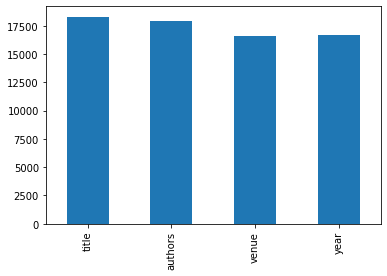

In [53]:
neg_ri_norms.sum(numeric_only=True).plot.bar()

### Positives

In [ ]:
pos_ri,pos_ri_norms = computeRi(hybrid_model.classifier,attributes,testpos,1)


 47%|████▋     | 208/444 [00:17<00:20, 11.38it/s]

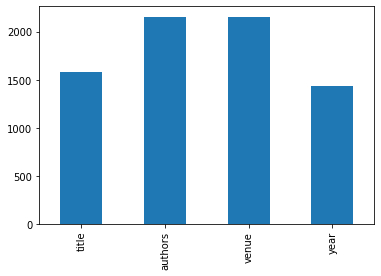

In [17]:
pos_ri_norms.sum(numeric_only=True).plot.bar()

In [19]:
torch.save(pos_ri,'experiment_results/testpos_ri.pt')

## Nearest neighbors discovery

In [26]:
from utils.distance_measures import calculate_nearest_neighbors_onAttributes

In [27]:
negatives_closer_vectors_df = calculate_nearest_neighbors_onAttributes(testneg_hybrid,testneg_ids_hybrid,
                                                                       neg_ri,positives_hybrid,pos_ids_hybrid,
                                                                      attributes,attribute_len,min_similarity=0.5)


100%|██████████| 128/128 [00:00<00:00, 295.31it/s]

100%|██████████| 128/128 [00:00<00:00, 357.02it/s]

100%|██████████| 128/128 [00:00<00:00, 457.48it/s][A

100%|██████████| 128/128 [00:00<00:00, 458.25it/s][A

100%|██████████| 109/109 [00:00<00:00, 457.55it/s][A

100%|██████████| 128/128 [00:00<00:00, 458.29it/s][A

100%|██████████| 128/128 [00:00<00:00, 457.79it/s][A

100%|██████████| 128/128 [00:00<00:00, 457.72it/s][A

100%|██████████| 128/128 [00:00<00:00, 459.14it/s][A

100%|██████████| 128/128 [00:00<00:00, 460.98it/s][A

100%|██████████| 128/128 [00:00<00:00, 459.09it/s][A

100%|██████████| 128/128 [00:00<00:00, 461.05it/s][A

100%|██████████| 128/128 [00:00<00:00, 457.54it/s][A

100%|██████████| 128/128 [00:00<00:00, 454.86it/s][A

100%|██████████| 128/128 [00:00<00:00, 462.36it/s][A

100%|██████████| 128/128 [00:00<00:00, 461.08it/s][A


In [28]:
negatives_closer_vectors_df.to_csv('experiment_results/testnegNNHybrid_filtered.csv',index=False)

In [29]:
positives_closer_vectors_df = calculate_nearest_neighbors_onAttributes(testpos_hybrid,testpos_ids,pos_ri,
                                                                      negatives_hybrid,neg_ids_hybrid,
                                                                      attributes,attribute_len,min_similarity=0.5)


100%|██████████| 128/128 [00:00<00:00, 133.43it/s]

100%|██████████| 128/128 [00:00<00:00, 170.80it/s]

100%|██████████| 128/128 [00:00<00:00, 171.24it/s]

100%|██████████| 60/60 [00:00<00:00, 170.76it/s]


In [34]:
positives_closer_vectors_df.to_csv('experiment_results/testposNNHybrid_w.csv',index=False)

## Test

In [24]:
import torch.nn.functional as F

In [36]:
from utils.ri_calculator import findPerturbationToFlipPredict

In [54]:
for key in testneg.keys():
    for idx,att in enumerate(attributes):
        pred = F.softmax(hybrid_model.classifier.forward(torch.unsqueeze(testneg[key]+neg_ri[key][idx],0)),dim=1)
        if (pred[0][0].item() >pred[0][1].item()):
            print((key,att))

In [31]:
for key in testpos.keys():
    for idx,att in enumerate(attributes):
        pred = F.softmax(hybrid_model.classifier.forward(torch.unsqueeze(testpos[key]+pos_ri[key][idx],0)),dim=1)
        if (pred[0][0].item() < pred[0][1].item()):
            print((key,att))

('10150', 'venue')
('11287', 'authors')
('10187', 'authors')
('11790', 'venue')
('10851', 'year')
('11795', 'title')
('11807', 'title')
('11807', 'venue')
('10448', 'venue')
('12413', 'year')
('12398', 'title')
('11976', 'venue')
('12472', 'year')
('10381', 'authors')
('10381', 'year')
('10576', 'authors')
('11264', 'authors')
('10991', 'venue')
('12198', 'authors')
('11729', 'title')
('11584', 'venue')
('12518', 'year')
